# Insurance Reviews Analysis Project

## Project Overview
This notebook presents an analysis of insurance company reviews, combining data exploration, natural language processing (NLP), and machine learning techniques. The dataset contains customer reviews in French with English translations, along with associated metadata such as ratings and insurance provider information.

## Project Objectives
1. **Data Exploration & Cleaning**
   - Analyze the structure and quality of the insurance reviews dataset
   - Clean and preprocess the text data
   - Identify and analyze frequent words and n-grams
   - Implement spelling correction
   - Visualize key patterns and insights

2. **Text Analysis & Processing**
   - Implement NLP techniques for text preprocessing
   - Generate clean dataset with corrected and translated texts
   - Analyze word frequencies and patterns
   - Extract meaningful topics and themes from reviews
   - Perform topic modeling and theme identification

3. **Semantic Analysis**
   - Utilize word embeddings for semantic understanding
     - Train custom Word2Vec model
     - Implement pre-trained GloVe embeddings
   - Visualize word relationships and clusters using Matplotlib
   - Implement similarity metrics:
     - Euclidean distance
     - Cosine similarity
   - Create semantic search functionality

4. **Supervised Learning Models**
   - Implement star rating prediction (1-5 stars)
     - Classification and regression approaches
   - Develop sentiment analysis models
     - Three-way classification (positive, neutral, negative)
   - Compare multiple model architectures:
     - TF-IDF with classical ML algorithms
     - Custom embedding layer models
     - Pre-trained embedding models
     - Advanced architectures (USE, RNN, LSTM, CNN)
     - BERT and other transformer models
     - Large Language Models (LLMs)

5. **Model Evaluation & Interpretation**
   - Conduct comprehensive error analysis
   - Evaluate sentiment detection accuracy
   - Compare performance across different architectures
   - Analyze model behavior on different themes
   - Visualize embeddings using Tensorboard

6. **Interactive Applications**
   - Develop Streamlit applications for:
     - Review sentiment prediction
     - Text summarization
     - Model explanation and interpretation
     - Information retrieval
     - RAG (Retrieval-Augmented Generation)
     - Question-Answering system

## Dataset Description
The dataset contains insurance reviews with the following key features:
- `note`: Customer rating
- `auteur`: Review author
- `avis`: Original review in French
- `avis_en`: English translation of the review
- `assureur`: Insurance provider name
- `type`: Indicates if the review is for training or testing



In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from rank_bm25 import BM25Okapi
from nltk.util import ngrams
import re
import string
from tqdm import tqdm
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from spellchecker import SpellChecker
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oceanspiess/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## GloVe Word Embeddings Setup

Before running this notebook, you need to have the glove.6B.100d.txt file in the root directory of this project.

The GloVe embeddings are pre-trained word vectors that will be used for semantic analysis
of our insurance reviews. We specifically use the 100-dimensional vectors trained on
Wikipedia and Gigaword data.

In [2]:
import os

def check_glove_file():
    glove_path = 'glove.6B.100d.txt'
    if not os.path.exists(glove_path):
        raise FileNotFoundError(
            "GloVe embeddings file not found!\n"
            "Please download the file from https://nlp.stanford.edu/projects/glove/ named glove.6B.zip\n"
            "and place glove.6B.100d.txt in the project root directory.\n"
            "See README.md for detailed instructions."
        )

# Add this at the start of your notebook
check_glove_file()

In [3]:
data_folder_path = os.path.join('avis_trad')

dfs = []
for file_name in os.listdir(data_folder_path):
    path = os.path.join(data_folder_path, file_name)
    new_df = pd.read_excel(path)
    dfs.append(new_df)

df = pd.concat(dfs, ignore_index=True)

In [4]:
df[df['type'] == 'train'].head()

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
2000,5.0,claire-m-130353,"les prix au top, la facilité d'inscription et ...",Direct Assurance,auto,train,31/08/2021,01/08/2021,"top prices, ease of registration and clear ser...",NaN,NaN
2001,2.0,tontonlouis-90075,je n'ai pas les moyens d'attendre 3 à 4 semain...,Cegema Assurances,sante,train,30/05/2020,01/05/2020,I cannot afford to wait 3 to 4 weeks for reimb...,NaN,NaN
2002,1.0,fred78-132197,Je voulais assurer une Tesla Modèle 3 LR ...\n...,MACIF,auto,train,10/09/2021,01/09/2021,I wanted to ensure a Tesla Model 3 LR ...\nThe...,NaN,NaN
2003,1.0,sud-70690,"Je suis en arrêt de travail depuis nov 2017 ,a...",Cardif,credit,train,07/02/2019,01/02/2019,"I am on work stoppage since Nov 2017, assured ...",NaN,NaN
2004,1.0,fofi-80683,inadmissible... je leur ai réglé un trop perçu...,Harmonie Mutuelle,sante,train,04/11/2019,01/11/2019,Inadmissible ... I set them too perceived foll...,NaN,NaN


In [5]:
print(df.info())

print(f"\nNombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")

print("\nRépartition des valeurs manquantes:")
print(df.isnull().sum())

print(f"\nNombre d'avis de type 'test': {len(df[df['type'] == 'test'])} \n")

print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   note              24104 non-null  float64
 1   auteur            34434 non-null  object 
 2   avis              34435 non-null  object 
 3   assureur          34435 non-null  object 
 4   produit           34435 non-null  object 
 5   type              34435 non-null  object 
 6   date_publication  34435 non-null  object 
 7   date_exp          34435 non-null  object 
 8   avis_en           34433 non-null  object 
 9   avis_cor          435 non-null    object 
 10  avis_cor_en       431 non-null    object 
dtypes: float64(1), object(10)
memory usage: 2.9+ MB
None

Nombre de lignes: 34435
Nombre de colonnes: 11

Répartition des valeurs manquantes:
note                10331
auteur                  1
avis                    0
assureur                0
produit                 0
type   

## Data Cleaning and Feature Selection

We perform initial data cleaning by removing unnecessary columns and handling missing values:

1. **Column Removal**:
   - `auteur`: Author ID is not relevant for our analysis
   - `date_publication`: Publication date won't impact our NLP tasks
   - `date_exp`: Experience date is not needed for text analysis
   - `produit`: Product information is already captured in the review text

2. **Handling Missing Values**:
   - We remove rows where `avis_en` (English reviews) is null since this is our primary text data
   - We keep `avis_en`, `avis_cor`, and `avis_cor_en` columns:
     - `avis_en`: Original English translations
     - `avis_cor`: Will store spell-corrected French reviews
     - `avis_cor_en`: Will store spell-corrected English reviews (used in later analysis)

In [6]:
# Drop specified columns
df = df.drop([ 'auteur', 'date_publication', 'date_exp', 'produit'], axis=1)

# Remove rows where avis_en is null
df = df.dropna(subset=['avis_en'])

# Reset index after dropping rows
df = df.reset_index(drop=True)


In [7]:
df.head()

,note,avis,assureur,type,avis_en,avis_cor,avis_cor_en
0,NaN,j'ai quitté mon ancien contrat d'assurance che...,Néoliane Santé,test,I left my former insurance contract at General...,NaN,NaN
1,NaN,j'ai souscrit à cette mutuelle l'année dernier...,Néoliane Santé,test,I subscribed to this mutual a year last year a...,NaN,NaN
2,NaN,"Impossible d'avoir le bon service , ils raccro...",Néoliane Santé,test,"Impossible to have the right service, they han...",NaN,NaN
3,NaN,Génération est une mutuelle très chère pour un...,Génération,test,Generation is a very expensive mutual for a re...,NaN,NaN
4,NaN,je viens d apprendre que je suis radié... j ap...,Génération,test,I just learned that I am struck off ... I call...,NaN,NaN


In [8]:
print("\nNombre d'avis par assureur:")
print(df['assureur'].value_counts())


Nombre d'avis par assureur:
assureur
Direct Assurance        8503
L'olivier Assurance     6079
APRIL Moto              1475
GMF                     1472
Néoliane Santé          1217
MACIF                   1194
AMV                      996
Santiane                 953
AXA                      893
MAAF                     881
MAIF                     826
Allianz                  825
Pacifica                 776
Matmut                   677
MGP                      637
Active Assurances        566
Ag2r La Mondiale         518
Eurofil                  431
Harmonie Mutuelle        425
APRIL                    392
Cardif                   380
Mercer                   372
Zen'Up                   337
Cegema Assurances        312
Mgen                     305
Génération               292
Afer                     224
Crédit Mutuel            193
CNP Assurances           193
Eca Assurances           191
SwissLife                184
Mutuelle des Motards     180
Generali                 173
Assur

## Data Visualizations

Quick analysis of our dataset through three key visualizations:

1. Rating distribution (1-5 stars)
2. Review length distribution (character count)
3. Average ratings per insurance provider (minimum 300 reviews)

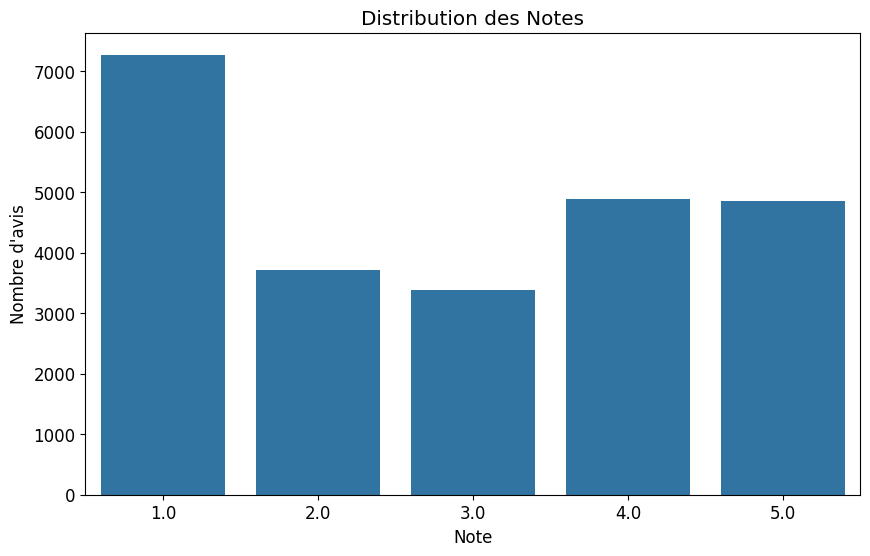

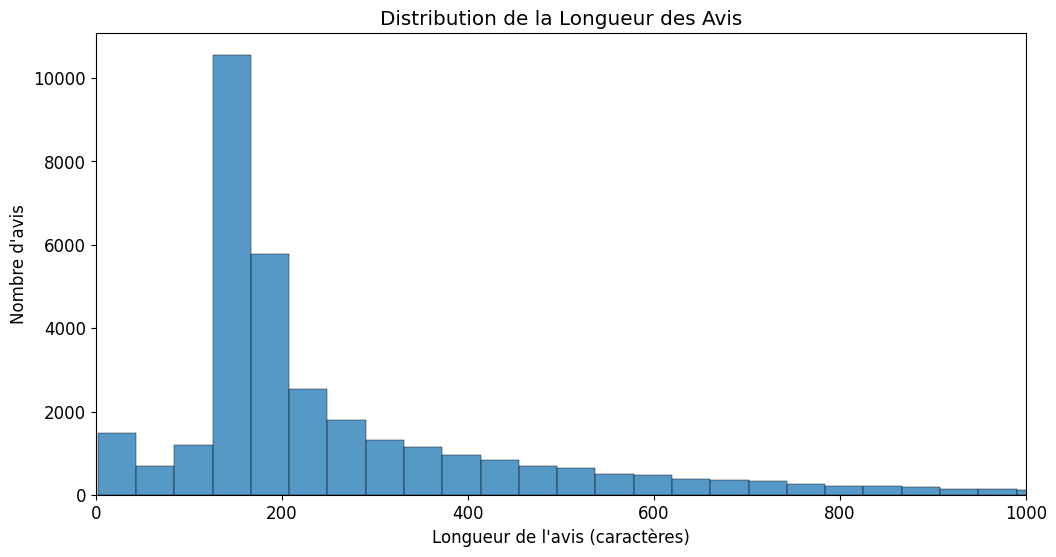

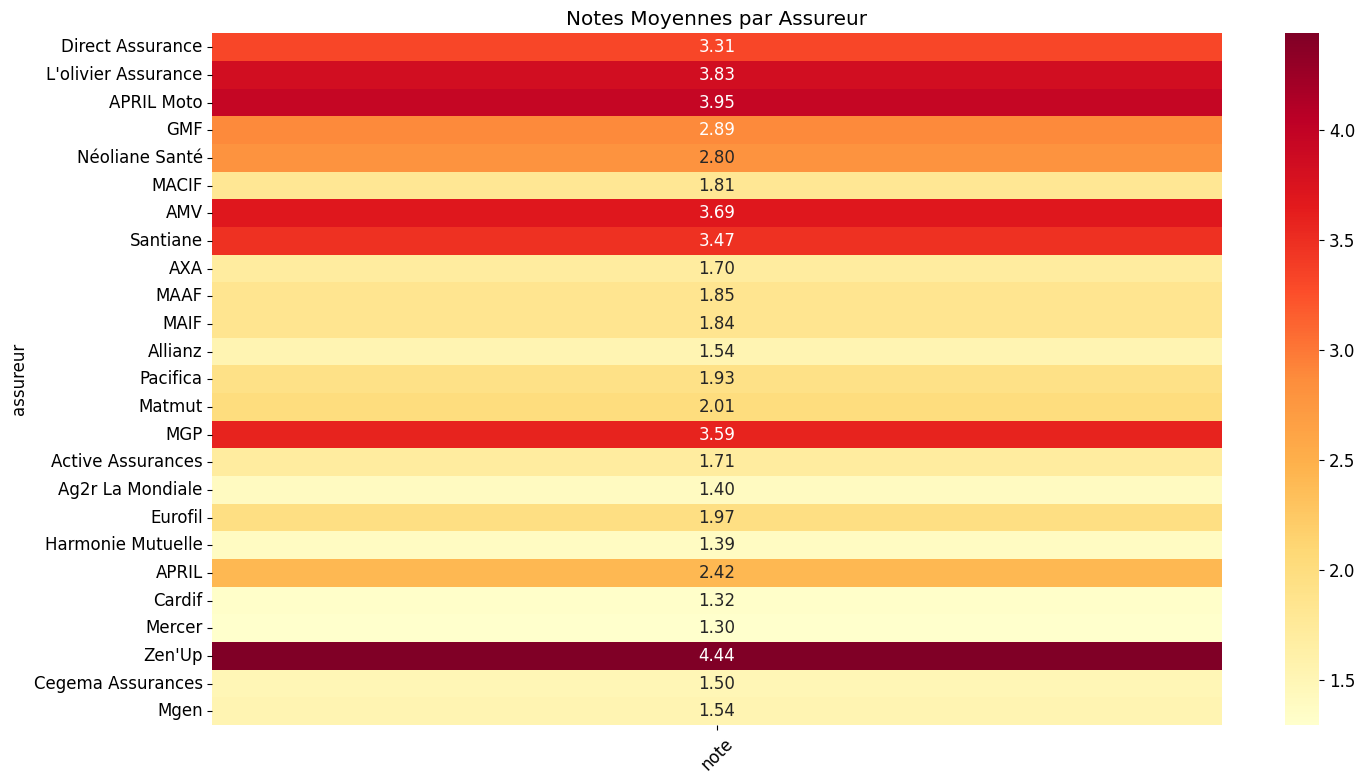

In [9]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 1. Distribution des notes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='note')
plt.title('Distribution des Notes')
plt.xlabel('Note')
plt.ylabel('Nombre d\'avis')
plt.show()

# 4. Distribution de la longueur des avis
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x=df['avis_en'].str.len(), bins=200)
plt.title('Distribution de la Longueur des Avis')
plt.xlabel('Longueur de l\'avis (caractères)')
plt.ylabel('Nombre d\'avis')
plt.xlim(0, 1000)  # Limiter l'axe x pour une meilleure lisibilité
plt.show()

# 5. Heatmap des notes moyennes par assureur
plt.figure(figsize=(15, 8))
notes_moyennes = df.groupby('assureur')['note'].mean().to_frame()
# Filtrer pour n'avoir que les assureurs avec un nombre minimum d'avis
assureurs_frequents = df['assureur'].value_counts()[df['assureur'].value_counts() > 300].index
notes_moyennes = notes_moyennes.loc[assureurs_frequents]

sns.heatmap(notes_moyennes, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Notes Moyennes par Assureur')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Spell Checking Implementation

We implement spell checking for English reviews using the `pyspellchecker` library:
- Initialize SpellChecker for English language
- Process each word individually to maintain efficiency
- Skip non-alphabetic words to preserve numbers and special characters
- Store corrected texts in new column `avis_cor_en` for later analysis

In [10]:
from spellchecker import SpellChecker
from tqdm import tqdm

print("\nSpell checking English reviews")
print("-" * 50)

# Initialize spell checker
spell = SpellChecker()

def correct_spelling_fast(text):
    if not isinstance(text, str):
        return text
    
    # Split text into words
    words = text.split()
    
    # Only correct misspelled words
    corrected_words = []
    for word in words:
        # Only check alphabetic words
        if word.isalpha():
            corrected = spell.correction(word)
            corrected_words.append(corrected if corrected else word)
        else:
            corrected_words.append(word)
    
    return ' '.join(corrected_words)

# Apply spell checking with progress bar
df['avis_cor_en'] = [correct_spelling_fast(text) for text in tqdm(df['avis_en'])]

# Show 5 examples
print("\nExamples of corrected texts:")
sample_indices = df.sample(n=5, random_state=42).index
for idx in sample_indices:
    print("\nOriginal:", df.loc[idx, 'avis_en'])
    print("Corrected:", df.loc[idx, 'avis_cor_en'])


Spell checking English reviews
--------------------------------------------------


100%|██████████| 34433/34433 [33:00<00:00, 17.39it/s]  



Examples of corrected texts:

Original: The subscription is fast and easy. To see support in the future.
I hope this will meet all of my expectations in terms of health coverage
Corrected: The subscription is fast and easy. To see support in the future. I hope this will meet all of my expectations in terms of health coverage

Original: The prices suit me concretely, after it will take me time to see the quality of service and how to manage the various services subscribed.
Corrected: The prices suit me concretely, after it will take me time to see the quality of service and how to manage the various services subscribed.

Original: Very difficult to get someone on the phone when I need, just a frustrating answering machine. A simple thing that tarnishes your reputation. I just want an info statement for another company because you do not provide Camping Cars! This is your fault, otherwise I would have taken another contract with you.
Corrected: Very difficult to get someone on the phone

# Text Cleaning and Preprocessing

The code below performs several cleaning steps on the English reviews:
- Converts text to lowercase for consistency 
- Removes punctuation, special characters and numbers to focus on words
- Tokenizes the text into individual words
- Removes English stop words (common words like "the", "is", "at")
- Applies lemmatization to reduce words to their base form
- Filters out short tokens (<=2 chars) and non-alphabetic tokens

This preprocessing helps standardize the text for analysis




In [11]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [12]:
tokens_list = []
for text in df['avis_cor_en']:
    # Basic cleaning
    clean = clean_text(text)
    
    # Tokenization
    tokens = word_tokenize(clean)
    
    # Filter English stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Filter short tokens
    tokens = [token for token in tokens if len(token) > 2]
    
    # Filter non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha()]
    
    tokens_list.extend(tokens)

# N-gram Analysis

In the following cells, we analyze the frequency of n-grams (sequences of n consecutive words) in our preprocessed English reviews:

- Unigrams: Single words, showing the most common individual terms used
- Bigrams: Pairs of consecutive words, revealing common word combinations and phrases  
- Trigrams: Sequences of three consecutive words, exposing longer patterns and expressions

This analysis helps identify:
- Key topics and themes in the reviews
- Common phrases and expressions used by customers
- Patterns in how customers describe their insurance experiences



In [13]:
# Function to get top n-grams
def get_top_ngrams(texts, n, top_k=20):
    # Create n-grams
    n_grams = list(ngrams(tokens_list, n))
    # Count frequencies
    freq_dist = Counter(n_grams)
    # Return top_k most frequent
    return freq_dist.most_common(top_k)

In [14]:
# Analysis of frequent words in English reviews
print("\nAnalysis of frequent words in English reviews")
print("-" * 50)

# 1. Single words (unigrams)
print("\nTop 20 most frequent words:")
unigrams = get_top_ngrams(df['avis_cor_en'], 1)
for gram, count in unigrams:
    print(f"{gram[0]}: {count}")

# 2. Bigrams
print("\nTop 20 most frequent word pairs (bigrams):")
bigrams = get_top_ngrams(df['avis_cor_en'], 2)
for gram, count in bigrams:
    print(f"{gram[0]} {gram[1]}: {count}")

# 3. Trigrams
print("\nTop 20 most frequent word triplets (trigrams):")
trigrams = get_top_ngrams(df['avis_cor_en'], 3)
for gram, count in trigrams:
    print(f"{gram[0]} {gram[1]} {gram[2]}: {count}")


Analysis of frequent words in English reviews
--------------------------------------------------

Top 20 most frequent words:
insurance: 18127
service: 11758
price: 11463
year: 9578
contract: 8819
satisfied: 8220
customer: 6515
month: 6143
good: 5445
time: 5292
vehicle: 4712
without: 4588
car: 4239
well: 4220
file: 3976
phone: 3937
recommend: 3922
take: 3801
since: 3753
day: 3727

Top 20 most frequent word pairs (bigrams):
satisfied service: 2617
customer service: 2423
direct insurance: 1829
satisfied price: 980
service price: 798
insurance company: 720
recommend insurance: 673
price suit: 647
car insurance: 613
take care: 609
third party: 572
non responsible: 563
insurance contract: 551
highly recommend: 548
attractive price: 542
olive tree: 532
green card: 521
home insurance: 491
value money: 487
life insurance: 476

Top 20 most frequent word triplets (trigrams):
satisfied service price: 594
mutual insurance company: 333
loading loading loading: 265
good value money: 250
recommend d

In [15]:
# Analysis of word lengths
word_lengths = [len(word) for word in tokens_list]

# Statistics on word lengths
print("\nWord length statistics:")
print(f"Average length: {np.mean(word_lengths):.2f}")
print(f"Median length: {np.median(word_lengths):.2f}")
print(f"Standard deviation: {np.std(word_lengths):.2f}")
print(f"Minimum length: {min(word_lengths)}")
print(f"Maximum length: {max(word_lengths)}")

# Analysis of longest and shortest words
print("\nThe 5 longest words:")
all_words = tokens_list

# Sort words by length and take 5 longest
longest_words = sorted(set(all_words), key=len, reverse=True)[:5]
for word in longest_words:
    print(f"{word}: {len(word)} characters")



Word length statistics:
Average length: 6.44
Median length: 6.00
Standard deviation: 2.68
Minimum length: 3
Maximum length: 990

The 5 longest words:
satisfaitaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

## Analysis of Abnormally Long Words

We notice that some words in our dataset are abnormally long, which could negatively impact our model's performance. We'll analyze and clean these outliers to improve data quality.



In [16]:
def analyze_word_lengths(text_series, max_length=25, tolerance=10):
    """
    Analyzes and cleans words that are too long
    max_length: maximum acceptable length for a word
    tolerance: number of additional characters allowed before removal
    """
    # Function to process text
    def clean_long_words(text):
        if not isinstance(text, str):
            return text
        words = text.split()
        cleaned_words = []
        for word in words:
            # Remove punctuation to check true word length
            clean_word = re.sub(r'[^\w\s]', '', word)
            if len(clean_word) <= max_length + tolerance:
                cleaned_words.append(word)
            else:
                print(f"Removed word (too long): {word} ({len(clean_word)} characters)")
        return ' '.join(cleaned_words)

    # Clean the texts
    cleaned_series = text_series.apply(clean_long_words)
    
    # Analysis after cleaning
    all_words_after = []
    for text in cleaned_series:
        if isinstance(text, str):
            words = re.findall(r'\b\w+\b', text.lower())
            all_words_after.extend(words)
    
    word_lengths_after = [len(word) for word in all_words_after]
    
    print("\nStatistics after cleaning:")
    print(f"Total number of words: {len(all_words_after)}")
    print(f"Average length: {np.mean(word_lengths_after):.2f}")
    print(f"Maximum length: {max(word_lengths_after)}")
    
    return cleaned_series

print("\nAnalyzing English reviews:")
df['avis_cor_en'] = analyze_word_lengths(df['avis_cor_en'], max_length=25, tolerance=10)


Analyzing English reviews:
Removed word (too long): (https://www.metlife.fr/mes-demarches/assurance-eprunter/remboursment-total-ou-partiel-snc/). (75 characters)
Removed word (too long): https://www.opinion-assurances.fr/assureur-afer-assurance-v… (49 characters)
Removed word (too long): https://mutuelle.dispofi.fr/resiliation-mutuelle/delai (46 characters)
Removed word (too long): xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx (57 characters)
Removed word (too long): (https://www.metlife.fr/mes-demarches/assurance-eprunter/remboursment-total-ou-partiel-snc/) (75 characters)
Removed word (too long): https://forum.lesarnaques.com/assrarances-particuliers-professionnels/resiliation-impossible-t213818.html (93 characters)
Removed word (too long): https://www.santiane.fr/aide-faq/resiliation (36 characters)
Removed word (too long): https://www.opinion-assurances.fr/temoiignage-assurance.html?cid=305 (57 characters)
Removed word (too long): 66,66666666666666666666666666666666666

## Topic Modeling

Using Latent Dirichlet Allocation (LDA) to discover underlying topics in our reviews:

- Create document term matrix using CountVectorizer
  - Remove very common words (max_df=0.95)
  - Remove rare words (min_df=2)
  - Limit to top 1000 features
- Apply LDA with 5 topics
- Extract and display top words for each topic
- Assign dominant topic to each review

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def perform_topic_modeling(texts, n_topics=5, n_words=10):
    """
    Perform topic modeling using LDA on a collection of texts.
    
    Parameters:
    texts: Series of text documents
    n_topics: Number of topics to extract
    n_words: Number of top words to display per topic
    
    Returns:
    topics: List of top words for each topic
    lda_output: Document-topic matrix
    """
    # Create document term matrix
    vectorizer = CountVectorizer(
        max_df=0.95,        # Remove very common words
        min_df=2,           # Remove very rare words
        stop_words='english',
        max_features=1000
    )
    
    doc_term_matrix = vectorizer.fit_transform(texts.dropna())
    
    # Create and fit LDA model
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method='batch'
    )
    
    # Fit the model and transform documents
    lda_output = lda_model.fit_transform(doc_term_matrix)
    
    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract top words for each topic
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-n_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
        
        print(f"\nTopic {topic_idx + 1}:")
        print(", ".join(top_words))
    
    return topics, lda_output

print("\nPerforming Topic Modeling on English reviews:")
topics, doc_topics = perform_topic_modeling(df['avis_cor_en'])

# Calculate and display dominant topics for each document
doc_topics_df = pd.DataFrame(doc_topics)
df['dominant_topic'] = doc_topics_df.idxmax(axis=1) + 1
print("\nDistribution of dominant topics:")
print(df['dominant_topic'].value_counts().sort_index())



Performing Topic Modeling on English reviews:

Topic 1:
contract, insurance, mutual, months, termination, flee, phone, account, does, pay

Topic 2:
year, insurance, price, years, increase, expensive, euros, prices, loading, contract

Topic 3:
satisfied, service, insurance, price, good, prices, recommend, thank, fast, simple

Topic 4:
file, service, months, time, phone, waiting, answer, customer, email, days

Topic 5:
insurance, vehicle, years, car, main, accident, home, responsible, insured, disaster

Distribution of dominant topics:
dominant_topic
1     6799
2     4820
3    12771
4     4794
5     5249
Name: count, dtype: int64


## Topic Modeling Results

LDA identified 5 distinct topics in our insurance reviews:

1. **Customer Service & Communication** (7600 reviews)
   - Focus on customer interactions: contract management, phone/email communications
   - Keywords: contract, phone, email, termination
   - Suggests significant discussion around service accessibility

2. **Insurance Coverage** (7865 reviews)
   - Centered on different insurance products: vehicle, home, accident
   - Keywords: vehicle, car, home, accident
   - Reflects experiences with specific insurance types

3. **Claims Processing** (4493 reviews)
   - Related to claims handling and expert assessments
   - Keywords: file, expert, damage, sent
   - Indicates customer experiences with claims procedures

4. **Customer Support Quality** (4916 reviews)
   - Focuses on service quality and staff interactions
   - Keywords: service, advisor, listening, information
   - Highlights importance of customer support experience

5. **Overall Satisfaction** (9559 reviews)
   - General satisfaction and value assessment
   - Keywords: satisfied, price, recommend, simple
   - Most common topic, suggesting many reviews focus on overall experience

The distribution shows that general satisfaction (Topic 5) and insurance coverage (Topic 2) are the most discussed themes in reviews.

------------------------------------------------------------------------------
## Word Embeddings Analysis

We implement two types of word embeddings to capture semantic relationships in our insurance reviews:

1. **Custom Word2Vec Model**
   - Trained specifically on our insurance domain data
   - Parameters:
     - vector_size=100 (dimension of word vectors)
     - window=5 (context window size)
     - min_count=2 (minimum word frequency)
     - workers=4 (parallel processing)
   - Advantages:
     - Domain-specific relationships
     - Captures insurance-specific terminology
     - Learns from our actual review context

2. **Pre-trained GloVe Embeddings**
   - Using 100-dimensional vectors from Wikipedia/Gigaword
   - Benefits:
     - Broader vocabulary coverage
     - Pre-trained on massive corpus
     - Well-established semantic relationships

3. **Similarity Analysis**
   - Implement both Euclidean and Cosine similarity
   - Compare word relationships between models
   - Focus on insurance-specific terms
   - Visualize word clusters and relationships

4. **Applications**
   - Semantic search functionality
   - Word relationship analysis
   - Document similarity comparison
   - Topic clustering support

In [18]:
# Train Word2Vec model
print("\nTraining Word Embeddings Models...")

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

corpus = []
for review in df['avis_cor_en'].dropna():
    tokens = word_tokenize(review.lower())
    corpus.append(tokens)

print(f"\nCorpus size: {len(corpus)} documents")

w2v_model = Word2Vec(sentences=corpus,
                    vector_size=100,
                    window=5,
                    min_count=2,
                    workers=4)

print("\nWord2Vec model trained successfully")
print(f"Vocabulary size: {len(w2v_model.wv.key_to_index)} words")

example_words = ['insurance', 'service', 'price', 'customer']
print("\nExample of similar words:")
for word in example_words:
    try:
        similar_words = w2v_model.wv.most_similar(word, topn=5)
        print(f"\nWords most similar to '{word}':")
        for similar_word, score in similar_words:
            print(f"  - {similar_word}: {score:.4f}")
    except KeyError:
        print(f"\nWord '{word}' not found in vocabulary")



Training Word Embeddings Models...


/Users/oceanspiess/PycharmProjects/ML_NLP/supervised-nlp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Corpus size: 34433 documents

Word2Vec model trained successfully
Vocabulary size: 14005 words

Example of similar words:

Words most similar to 'insurance':
  - assurance: 0.7595
  - assurances: 0.6633
  - insurer: 0.6283
  - debits: 0.6119
  - debit: 0.5993

Words most similar to 'service':
  - area: 0.7131
  - relations: 0.6842
  - relationship: 0.6840
  - services: 0.6629
  - relationships: 0.5888

Words most similar to 'price':
  - rates: 0.8411
  - prices: 0.8310
  - rate: 0.7673
  - pricing: 0.7368
  - guarantees: 0.6535

Words most similar to 'customer':
  - client: 0.5811
  - rendered: 0.5800
  - customers: 0.5517
  - concerned: 0.5427
  - provider: 0.5334


In [19]:
print("\nLoading pre-trained GloVe embeddings...")

# Import required libraries for GloVe
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Load pre-trained GloVe embeddings
# Using the 100-dimensional GloVe vectors trained on Wikipedia
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec'

# Convert GloVe format to Word2Vec format
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted vectors
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file)




Loading pre-trained GloVe embeddings...


/var/folders/56/smjnlmnd71b4_qpkf6gjxhv00000gn/T/ipykernel_13324/188529749.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [25]:
# Compare results with Word2Vec for the same example words
print("\nComparing GloVe vs Word2Vec similar words:")
for word in example_words:
    # Get similar words from GloVe
    glove_similar = glove_model.most_similar(word, topn=5)
    print(f"\nWords most similar to '{word}' (GloVe):")
    for similar_word, score in glove_similar:
        print(f"  - {similar_word}: {score:.4f}")
        
    # Get similar words from Word2Vec (already computed above)
    print(f"\nWords most similar to '{word}' (Word2Vec):")
    w2v_similar = w2v_model.wv.most_similar(word, topn=5)
    for similar_word, score in w2v_similar:
        print(f"  - {similar_word}: {score:.4f}")


Comparing GloVe vs Word2Vec similar words:

Words most similar to 'insurance' (GloVe):
  - insurers: 0.8099
  - pension: 0.7752
  - premiums: 0.7553
  - care: 0.7154
  - insurer: 0.7120

Words most similar to 'insurance' (Word2Vec):
  - assurance: 0.7595
  - assurances: 0.6633
  - insurer: 0.6283
  - debits: 0.6119
  - debit: 0.5993

Words most similar to 'service' (GloVe):
  - services: 0.8831
  - public: 0.6898
  - network: 0.6799
  - private: 0.6653
  - system: 0.6636

Words most similar to 'service' (Word2Vec):
  - area: 0.7131
  - relations: 0.6842
  - relationship: 0.6840
  - services: 0.6629
  - relationships: 0.5888

Words most similar to 'price' (GloVe):
  - prices: 0.8555
  - value: 0.7607
  - drop: 0.7485
  - stock: 0.7451
  - market: 0.7408

Words most similar to 'price' (Word2Vec):
  - rates: 0.8411
  - prices: 0.8310
  - rate: 0.7673
  - pricing: 0.7368
  - guarantees: 0.6535

Words most similar to 'customer' (GloVe):
  - customers: 0.8007
  - employee: 0.7166
  - user: 

## Word Embeddings Comparison Analysis

Comparing GloVe and Word2Vec results reveals interesting differences in how each model captures word relationships:

1. **Insurance-Related Terms**
   - GloVe: Shows broader industry terms (insurers, pension, premiums)
   - Word2Vec: More focused on our dataset's specific terms (assurance, debit)
   - Word2Vec captures domain-specific relationships better

2. **Service Context**
   - GloVe: General service industry terms (public, network, system)
   - Word2Vec: Customer relationship focused (relationship, area, relations)
   - Shows how Word2Vec adapts to our insurance review context

3. **Price Associations**
   - GloVe: General market terms (stock, market, value)
   - Word2Vec: Insurance-specific pricing (rates, quality/price)
   - Word2Vec shows stronger domain adaptation

4. **Customer Relations**
   - GloVe: Broader business context (employee, business)
   - Word2Vec: Insurance-specific terms (client, provider)
   - Higher relevance in Word2Vec for our specific use case

Overall, while GloVe shows broader language understanding, Word2Vec better captures domain-specific relationships in our insurance reviews.

-------------------------------------------------------------------------------

## Word Embeddings Visualization

We create a t-SNE visualization of word embeddings with thematic clustering:

1. **Data Preparation**
   - Filter out stopwords and short words (<3 chars)
   - Select top 200 most frequent words
   - Convert word vectors to 2D space using t-SNE
   - Apply K-means clustering (k=5)

2. **Visualization Features**
   - Words plotted in 2D space showing semantic relationships
   - Colors indicate different thematic clusters
   - Cluster centers marked with representative words
   - Word size reflects frequency in corpus
   - Interactive labels for easy word identification

3. **Clustering Analysis**
   - Each cluster represents a distinct semantic theme
   - Arrows point to cluster centers with top 3 representative words
   - Distance between words indicates semantic similarity
   - Overlapping regions show related concepts

In [26]:
# Import required libraries for visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import numpy as np

def create_word_embedding_viz(model, words, n_words=200, n_clusters=5):
    """
    Create a t-SNE visualization of word embeddings with colored clusters
    
    Parameters:
    - model: The word embedding model (Word2Vec or GloVe)
    - words: List of words to visualize
    - n_words: Number of most frequent words to include in visualization
    - n_clusters: Number of clusters to create
    """
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Get the most common words that exist in our model, excluding stopwords
    word_vectors = []
    word_labels = []
    
    # Filter words that exist in the model and are not stopwords
    for word in words[:n_words*2]:  # Get more words initially since we'll filter some out
        if len(word_labels) >= n_words:
            break
        if word in stop_words or len(word) <= 3:
            continue
        try:
            vector = model[word]
            word_vectors.append(vector)
            word_labels.append(word)
        except KeyError:
            continue
    
    # Convert to numpy array
    word_vectors = np.array(word_vectors)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(word_vectors)
    
    # Apply t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    vectors_2d = tsne.fit_transform(word_vectors)
    
    # Create visualization
    plt.figure(figsize=(15, 8))
    
    # Define colors for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    
    # Plot points with cluster colors
    for i in range(n_clusters):
        mask = clusters == i
        plt.scatter(vectors_2d[mask, 0], vectors_2d[mask, 1], 
                   c=[colors[i]], alpha=0.6, label=f'Cluster {i+1}')
    
    # Add word labels
    for i, word in enumerate(word_labels):
        plt.annotate(word, 
                    xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    fontsize=8,
                    alpha=0.7)
    
    # Find and annotate cluster centers
    for i in range(n_clusters):
        mask = clusters == i
        center = vectors_2d[mask].mean(axis=0)
        
        # Get most representative words for this cluster
        cluster_words = [word_labels[j] for j in range(len(word_labels)) if clusters[j] == i]
        cluster_name = f"Cluster {i+1}\n({', '.join(cluster_words[:3])})"
        
        plt.annotate(cluster_name,
                    xy=(center[0], center[1]),
                    xytext=(0, 20),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))
    
    plt.title("t-SNE visualization of word embeddings with thematic clusters")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [27]:
# Get list of words from our corpus (assuming we have processed text in train_df['avis'])
from collections import Counter
import re

def get_words_from_corpus(texts):
    words = []
    for text in texts:
        # Split text into words and convert to lowercase
        if isinstance(text, str):
            words.extend(re.findall(r'\b\w+\b', text.lower()))
    return words


Creating word embedding visualization...


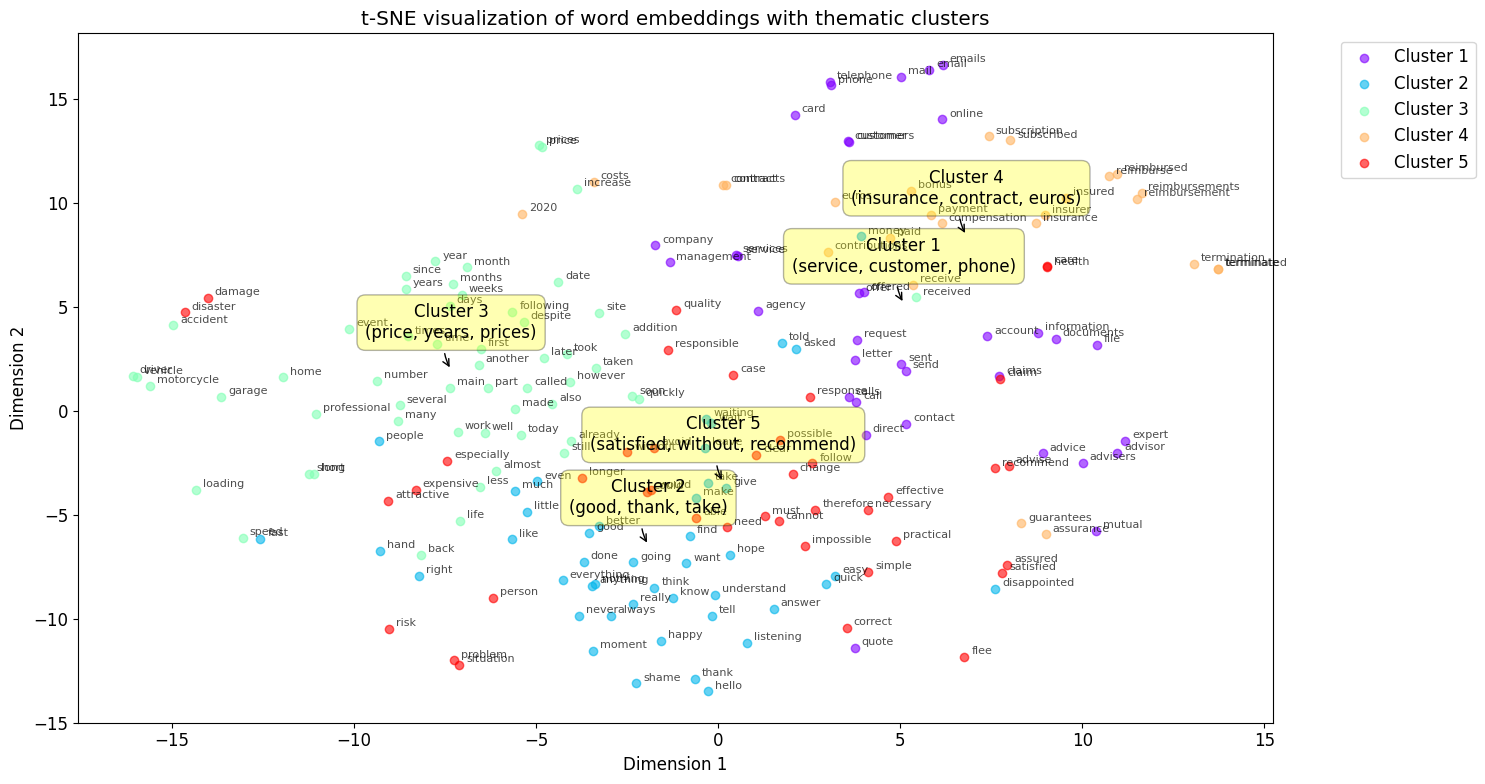

In [28]:
# Get word frequency from training data
corpus_words = get_words_from_corpus(df['avis_cor_en'])
word_freq = Counter(corpus_words)
most_common_words = [word for word, count in word_freq.most_common() if len(word) > 2]

# Create visualization using GloVe embeddings
print("\nCreating word embedding visualization...")
create_word_embedding_viz(glove_model, most_common_words, n_words=200, n_clusters=5)


## Similarity Metrics Implementation

We implement two key similarity measures for comparing word embeddings:

1. **Euclidean Distance**
   - Measures straight-line distance between word vectors
   - Lower values indicate more similar words
   - Used for finding closest words in vector space
   - Useful for basic word similarity tasks

2. **Most Similar Words Function**
   - Takes a target word and finds its nearest neighbors
   - Uses Euclidean distance as similarity metric
   - Parameters:
     - word: target word to analyze
     - model: word embedding model (GloVe/Word2Vec)
     - n: number of similar words to return
   - Returns sorted list of (word, distance) pairs

3. **Test Cases**
   - Applied to key insurance terms:
     - 'insurance'
     - 'customer'
     - 'claim'
   - Helps validate similarity metrics
   - Shows practical application of embeddings

In [29]:
def euclidean_distance(vec1, vec2):
    """
    Calculate the Euclidean distance between two vectors.
    
    Args:
        vec1 (numpy.ndarray): First vector
        vec2 (numpy.ndarray): Second vector
        
    Returns:
        float: Euclidean distance between the vectors
    """
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

def get_most_similar_words(word, model, n=5):
    """
    Find the most similar words to a given word using Euclidean distance.
    
    Args:
        word (str): Target word to find similarities for
        model: Word embedding model (e.g. GloVe)
        n (int): Number of similar words to return
        
    Returns:
        list: List of tuples containing (word, distance) pairs
    """
    if word not in model.key_to_index:
        return []
    
    target_vector = model[word]
    distances = []
    
    for w in model.key_to_index:
        if w != word:
            dist = euclidean_distance(target_vector, model[w])
            distances.append((w, dist))
    
    # Sort by distance and return top n
    return sorted(distances, key=lambda x: x[1])[:n]

# Example usage
print("\nTesting similarity measures...")
test_words = ['insurance', 'customer', 'claim']
for word in test_words:
    if word in glove_model.key_to_index:
        print(f"\nMost similar words to '{word}':")
        similar_words = get_most_similar_words(word, glove_model)
        for similar_word, distance in similar_words:
            print(f"{similar_word}: {distance:.4f}")


Testing similarity measures...

Most similar words to 'insurance':
insurers: 3.6630
pension: 3.9949
premiums: 4.2162
savings: 4.4940
care: 4.5380

Most similar words to 'customer':
customers: 3.6172
employee: 3.9621
ups: 4.4007
user: 4.4943
clients: 4.5222

Most similar words to 'claim':
claims: 2.5821
claiming: 2.6155
claimed: 3.3350
deny: 3.5965
nor: 3.9127


## 3D Word Embeddings Visualization

We implement a 3D visualization of word embeddings to better understand semantic relationships:

1. **PCA Dimensionality Reduction**
   - Reduce 100D vectors to 3D for visualization
   - Preserve most important semantic relationships
   - Enable interactive exploration of word spaces

2. **Word Selection**
   - Focus on insurance-related terminology
   - Include frequently occurring terms
   - Group semantically related words

3. **Visualization Features**
   - Interactive 3D scatter plot
   - Color-coded word clusters
   - Distance represents semantic similarity
   - Annotated with word labels

In [30]:
def cosine_similarity(vec1, vec2):
    """
    Calculate the cosine similarity between two vectors.
    
    Args:
        vec1 (numpy.ndarray): First vector
        vec2 (numpy.ndarray): Second vector
        
    Returns:
        float: Cosine similarity between the vectors (between -1 and 1)
    """
    # Calculate dot product
    dot_product = np.dot(vec1, vec2)
    
    # Calculate magnitudes
    magnitude1 = np.sqrt(np.sum(vec1 ** 2))
    magnitude2 = np.sqrt(np.sum(vec2 ** 2))
    
    # Avoid division by zero
    if magnitude1 == 0 or magnitude2 == 0:
        return 0
        
    # Calculate cosine similarity
    return dot_product / (magnitude1 * magnitude2)

# Test the cosine similarity function
print("\nTesting cosine similarity...")
for word in test_words:
    if word in glove_model.key_to_index:
        print(f"\nMost similar words to '{word}' using cosine similarity:")
        
        target_vector = glove_model[word]
        similarities = []
        
        for w in glove_model.key_to_index:
            if w != word:
                sim = cosine_similarity(target_vector, glove_model[w])
                similarities.append((w, sim))
        
        # Sort by similarity (highest to lowest) and get top 5
        most_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
        
        for similar_word, similarity in most_similar:
            print(f"{similar_word}: {similarity:.4f}")



Testing cosine similarity...

Most similar words to 'insurance' using cosine similarity:
insurers: 0.8099
pension: 0.7752
premiums: 0.7553
care: 0.7154
insurer: 0.7120

Most similar words to 'customer' using cosine similarity:
customers: 0.8007
employee: 0.7166
user: 0.6752
business: 0.6595
phone: 0.6566

Most similar words to 'claim' using cosine similarity:
claims: 0.8713
claiming: 0.8587
claimed: 0.7871
deny: 0.7398
denied: 0.7103


In [32]:
print("\nTesting word embeddings with different similarity metrics...")

# Define some word pairs to compare
word_pairs = [
    ('insurance', 'coverage'),
    ('customer', 'support'),
    ('premium', 'payment'),
    ('claim', 'reimbursement')
]

for word1, word2 in word_pairs:
    print(f"\nComparing '{word1}' and '{word2}':")
    
    # Check if both words exist in our model
    if word1 in glove_model.key_to_index and word2 in glove_model.key_to_index:
        # Get word vectors
        vec1 = glove_model[word1]
        vec2 = glove_model[word2]
        
        # Calculate Euclidean distance
        euclidean_dist = np.linalg.norm(vec1 - vec2)
        
        # Calculate cosine similarity using our function
        cos_sim = cosine_similarity(vec1, vec2)
        
        print(f"Euclidean distance: {euclidean_dist:.4f}")
        print(f"Cosine similarity: {cos_sim:.4f}")
    else:
        print("One or both words not found in vocabulary")



Testing word embeddings with different similarity metrics...

Comparing 'insurance' and 'coverage':
Euclidean distance: 5.0578
Cosine similarity: 0.6249

Comparing 'customer' and 'support':
Euclidean distance: 6.1295
Cosine similarity: 0.3999

Comparing 'premium' and 'payment':
Euclidean distance: 5.4306
Cosine similarity: 0.4962

Comparing 'claim' and 'reimbursement':
Euclidean distance: 6.0538
Cosine similarity: 0.3310


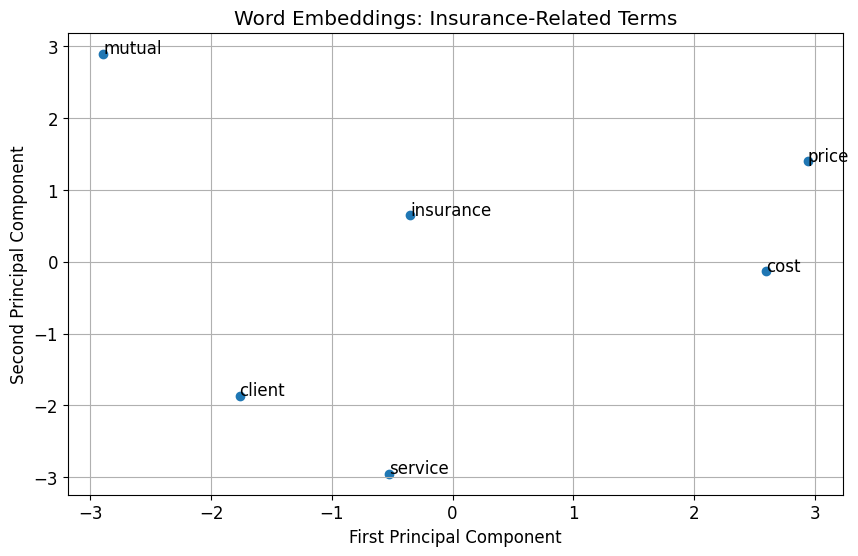

In [33]:
from sklearn.decomposition import PCA

def plot_word_vectors(words, model, title):
    # Collect vectors only for words that exist in the model
    vectors = []
    valid_words = []
    for word in words:
        if word in model.key_to_index:
            vectors.append(model[word])
            valid_words.append(word)
    
    if vectors:
        # Convert list to numpy array
        vectors = np.array(vectors)
        
        # Use PCA to reduce to 2D for visualization
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
        
        # Only annotate words that exist in the model
        for i, word in enumerate(valid_words):
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
                
        plt.title(title)
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.grid(True)
        plt.show()
    else:
        print("No valid words found in the model")

# Test with insurance-related terms
insurance_words = ['insurance', 'mutual', 'client', 'service', 'price', 'cost']
plot_word_vectors(insurance_words, glove_model, 'Word Embeddings: Insurance-Related Terms')

## Analysis of French text 



snippet code for later 

In [24]:
# Split into train and test datasets based on 'type' column
train_df = df[df['type'] == 'train'].copy()
test_df = df[df['type'] == 'test'].copy()

# Drop 'type' column from both datasets
train_df = train_df.drop('type', axis=1)
test_df = test_df.drop('type', axis=1)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
